In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,16695,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,5120,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,18391,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,495,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,16408,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1


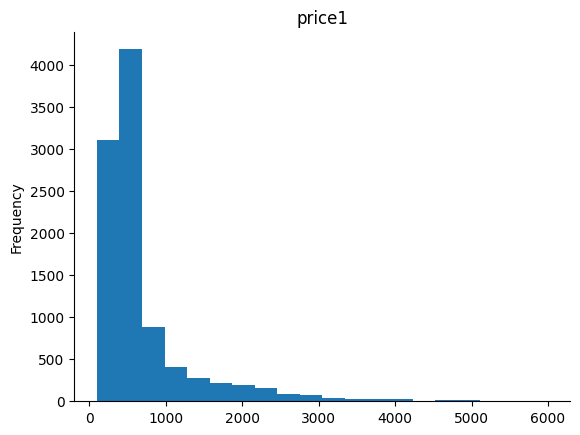

In [ ]:
# @title price1

from matplotlib import pyplot as plt
train_df['price1'].plot(kind='hist', bins=20, title='price1')
plt.gca().spines[['top', 'right',]].set_visible(False)

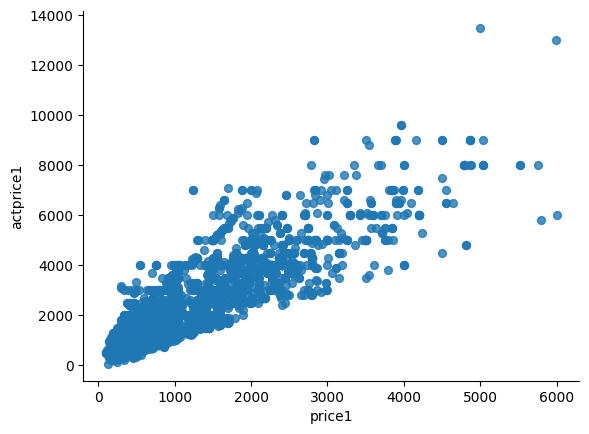

In [ ]:
# @title price1 vs actprice1

from matplotlib import pyplot as plt
train_df.plot(kind='scatter', x='price1', y='actprice1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# @title Rating

from matplotlib import pyplot as plt
train_df['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train_df.shape
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15730 entries, 0 to 15729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15730 non-null  int64  
 1   title       15730 non-null  object 
 2   Rating      15730 non-null  float64
 3   maincateg   15204 non-null  object 
 4   platform    15730 non-null  object 
 5   price1      15730 non-null  int64  
 6   actprice1   15730 non-null  int64  
 7   Offer %     15730 non-null  object 
 8   norating1   15052 non-null  float64
 9   noreviews1  15152 non-null  float64
 10  star_5f     15142 non-null  float64
 11  star_4f     15191 non-null  float64
 12  star_3f     15499 non-null  float64
 13  star_2f     15730 non-null  int64  
 14  star_1f     15730 non-null  int64  
 15  fulfilled1  15730 non-null  int64  
dtypes: float64(6), int64(6), object(4)
memory usage: 1.9+ MB


In [ ]:
train_df.isnull().sum()

id              0
title           0
Rating          0
maincateg     526
platform        0
price1          0
actprice1       0
Offer %         0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

In [ ]:
# Convert the Offer % column to float
train_df['Offer %'] = train_df['Offer %'].str[:4].astype('float')

# Fill in the missing values in the norating1 and noreviews1 columns
train_df['norating1'] = train_df['norating1'].fillna(train_df['norating1'].sum())
train_df['noreviews1'] = train_df['noreviews1'].fillna(train_df['noreviews1'].sum())

# Create a new column called total_cus that sums the values of the norating1, star_5f, star_4f, star_3f, star_2f, and star_1f columns
total_cus = train_df['norating1'] + train_df['star_5f'] + train_df['star_4f'] + train_df['star_3f'] + train_df['star_2f'] + train_df['star_1f']
train_df['total_cus'] = total_cus

# Drop the star_5f, star_4f, star_3f, star_2f, and star_1f columns
train_df = train_df.drop(['star_5f', 'star_4f', 'star_3f', 'star_2f', 'star_1f'], axis=1)

# Drop the norating1 and noreviews1 columns
train_df = train_df.drop(['norating1', 'noreviews1'], axis=1)

# Convert the platform column to numeric
train_df['platform'] = train_df['platform'].map({'Flipkart': 0, 'Amazon': 1})

# If the maincateg column is null, set it to "Unknown"
train_df.loc[train_df['maincateg'].isnull(), 'maincateg'] = 'Unknown'

# Check if there are any null values in the maincateg column
print(train_df['maincateg'].isnull().sum())

0


In [ ]:
print(train_df['maincateg'].unique())

['Women' 'Men' 'Unknown']


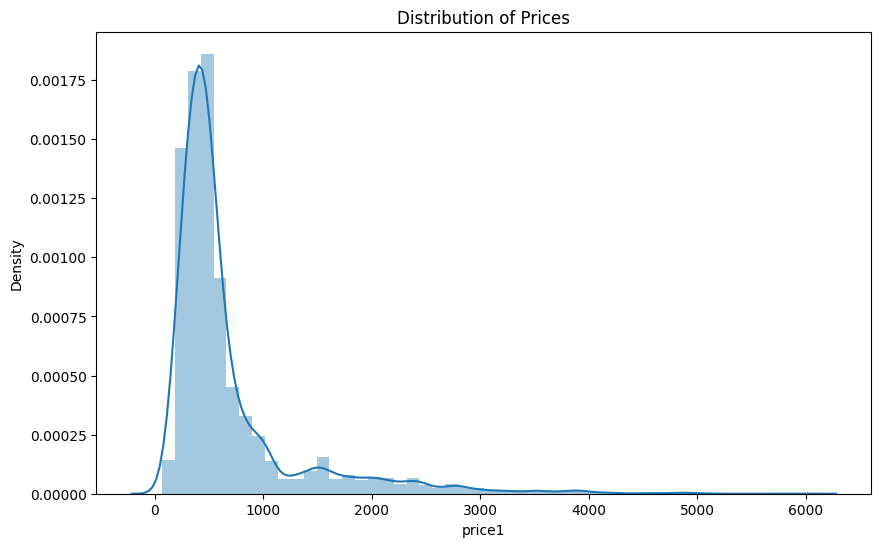

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(train_df['price1'])
plt.title('Distribution of Prices')
plt.show()

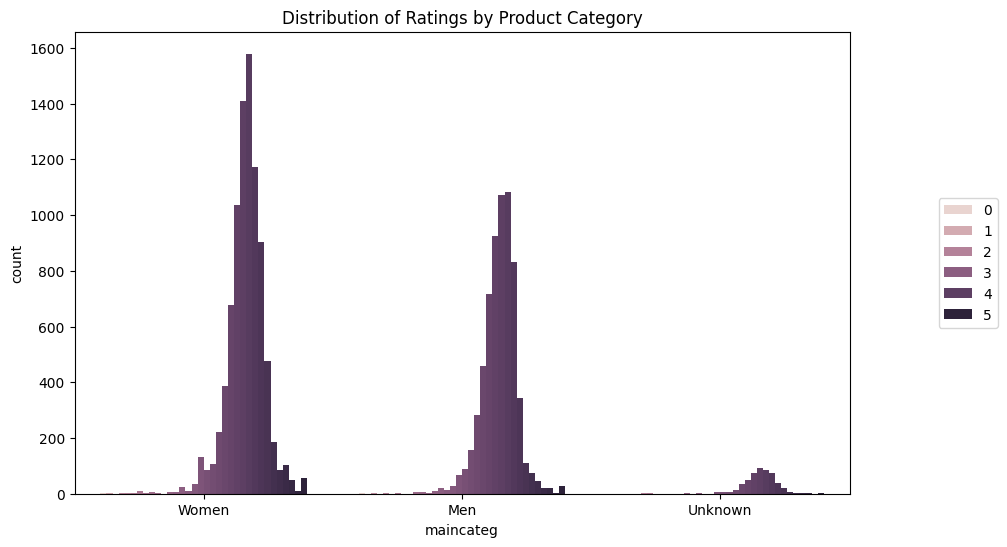

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom color palette
#palette = ["skyblue", "lightcoral", "lightgreen"]

#sns.countplot(x='maincateg', hue='Rating', data=train_df, palette=palette)
plt.figure(figsize=(10, 6))
sns.countplot(x='maincateg', hue='Rating', data=train_df)
plt.title('Distribution of Ratings by Product Category')
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right')
plt.show()

<Figure size 1200x600 with 0 Axes>

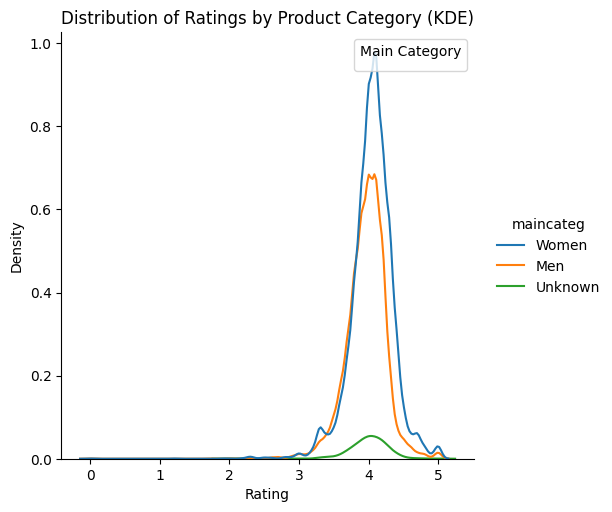

In [ ]:
plt.figure(figsize=(12, 6))
sns.displot(x='Rating', hue='maincateg', kind='kde', data=train_df)
plt.title('Distribution of Ratings by Product Category (KDE)')
plt.legend(title='Main Category', loc='upper right')
plt.show()

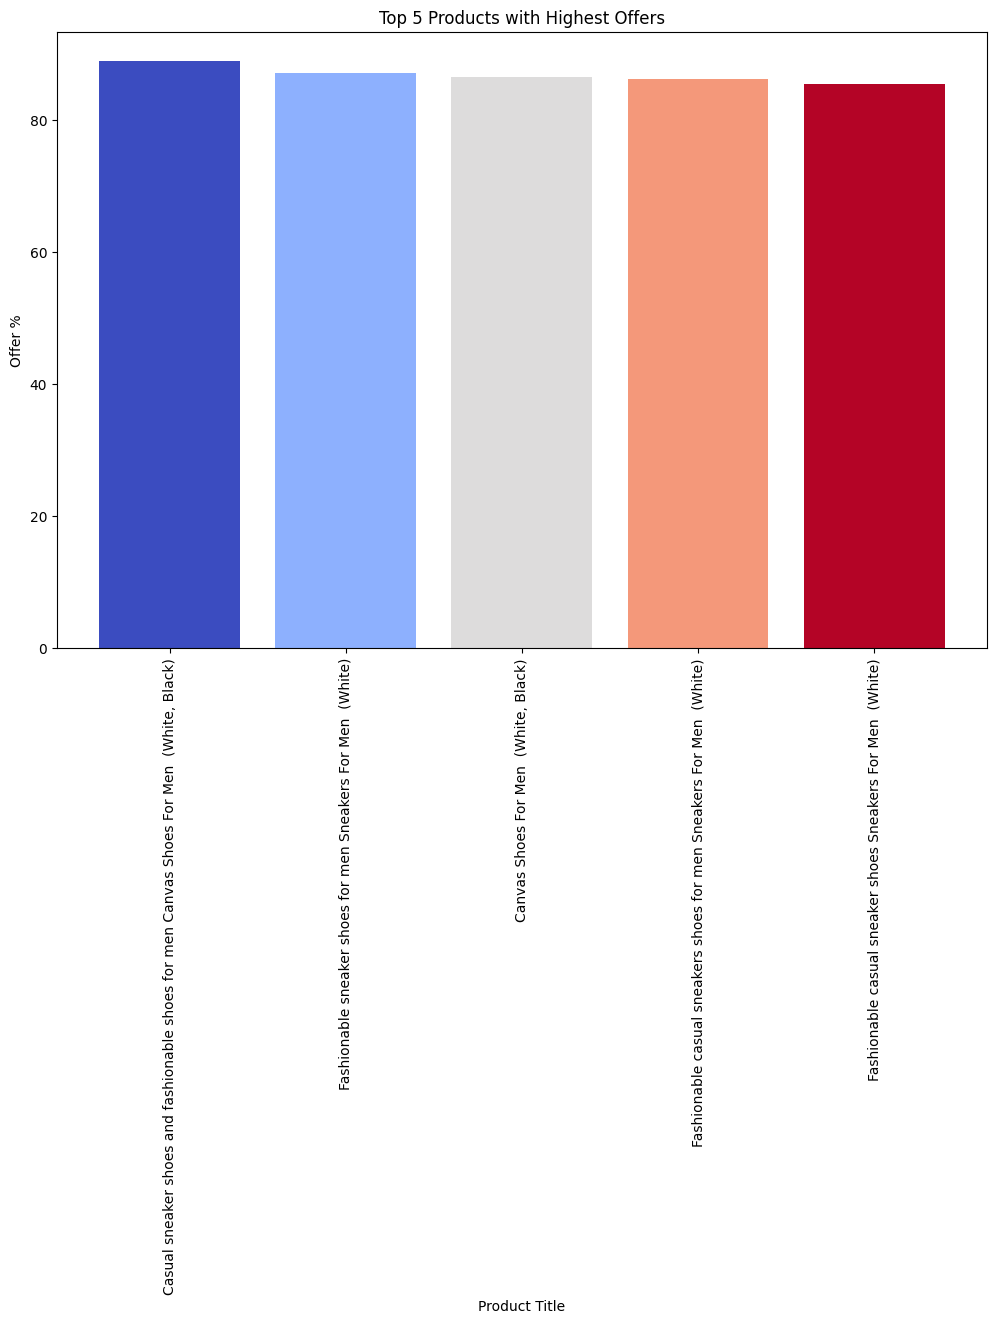

In [ ]:
plt.figure(figsize=(12, 8))
colormap = 'coolwarm'
# Create a color mapper object
cmap = plt.cm.get_cmap(colormap)
top_5_titles = train_df.groupby('title')['Offer %'].mean().sort_values(ascending=False).head(5)
# Get number of bars (assuming len(top_5_titles) reflects the number of bars)
num_bars = len(top_5_titles)

# Create a list of colors using the colormap for each bar
colors = [cmap(i / (num_bars - 1)) for i in range(num_bars)]

# Plot the bars with custom colors
plt.bar(top_5_titles.index, top_5_titles.values, color=colors)
plt.title('Top 5 Products with Highest Offers')
plt.xlabel('Product Title')
plt.ylabel('Offer %')
plt.xticks(rotation=90)
plt.show()

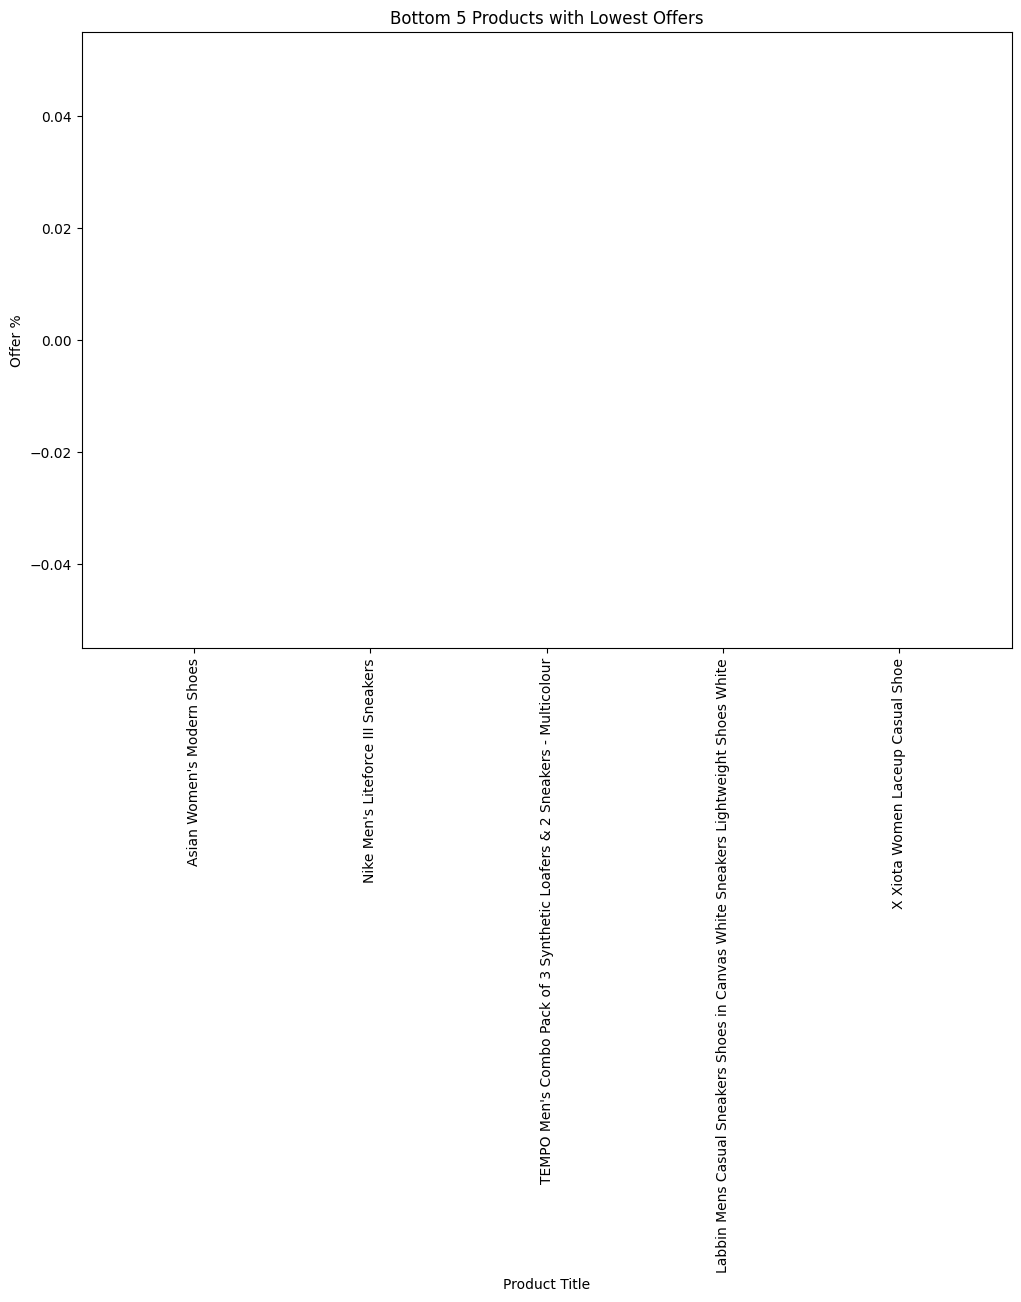

In [ ]:
plt.figure(figsize=(12, 8))
colormap = 'viridis'
bottom_5_titles = train_df.groupby('title')['Offer %'].mean().sort_values(ascending=True).head(5)
# Create a color mapper object
cmap = plt.cm.get_cmap(colormap)
num_bars = len(bottom_5_titles)
colors = [cmap(i / (num_bars - 1)) for i in range(num_bars)]

# Plot the bars with custom colors
plt.bar(bottom_5_titles.index, bottom_5_titles.values, color=colors)
plt.title('Bottom 5 Products with Lowest Offers')
plt.xlabel('Product Title')
plt.ylabel('Offer %')
plt.xticks(rotation=90)
plt.show()

Total number of rows: 15730
Number of potential outliers: 1990


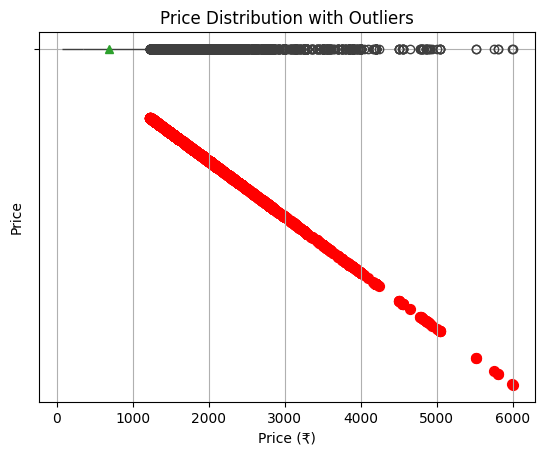

In [ ]:
# Calculate IQR and bounds ('train_df' data)
Q1 = train_df['price1'].quantile(0.25)
Q3 = train_df['price1'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identify outliers
outliers = train_df[(train_df['price1'] > upper_bound) | (train_df['price1'] < lower_bound)]
total_rows = len(train_df)
print("Total number of rows:", total_rows)
print("Number of potential outliers:", outliers.shape[0])
# Create boxplot
sns.boxplot(
    x = "price1",
    showmeans=True,  # Showing the mean as a point
    data=train_df
)

# Mark outliers (red circles)
plt.scatter(outliers['price1'], outliers['price1'], color='red', marker='o', s=50)

plt.title('Price Distribution with Outliers')
plt.xlabel('Price (₹)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Total number of rows: 15730
Number of potential outliers: 1990


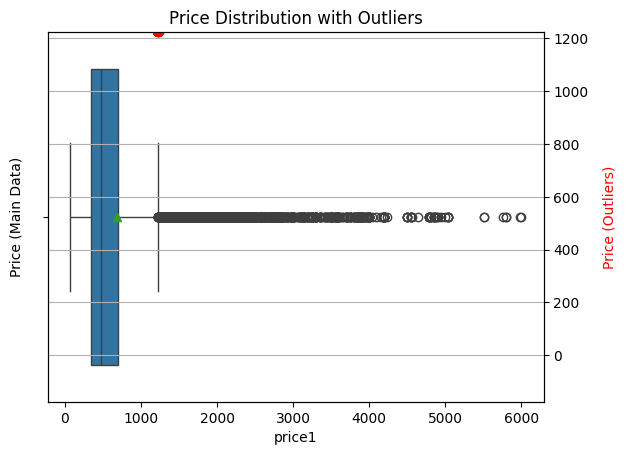

In [ ]:
import matplotlib.pyplot as plt
# Calculate IQR and bounds ('train_df' data)
Q1 = train_df['price1'].quantile(0.25)
Q3 = train_df['price1'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identify outliers
outliers = train_df[(train_df['price1'] > upper_bound) | (train_df['price1'] < lower_bound)]
total_rows = len(train_df)
print("Total number of rows:", total_rows)
print("Number of potential outliers:", outliers.shape[0])

sns.boxplot(
    x="price1",
    showmeans=True,
    data=train_df
)

# Get the main y-axis
ax = plt.gca()

# Set label for the main y-axis
ax.set_ylabel('Price (Main Data)', labelpad=10)

# Create the secondary y-axis for outliers
ax2 = plt.twinx()

# Plot outliers on the secondary axis (unchanged)
ax2.scatter(outliers['price1'], outliers['price1'], color='red', marker='o', s=50)

# Set label and limits for the outlier axis
ax2.set_ylabel('Price (Outliers)', labelpad=10, color='red')
ax2.set_ylim(bottom=lower_bound, top=upper_bound)

plt.title('Price Distribution with Outliers')
plt.xlabel('Price (₹)')
plt.grid(True)
plt.show()


In [ ]:
# Rating distribution
# Create the DataFrame
df = pd.read_csv('train.csv')
rating_counts = df['Rating'].value_counts()

# Print rating distribution
print("Distribution of information based on ratings:")
print(rating_counts)


Distribution of information based on ratings:
Rating
4.1    2748
4.0    2574
4.2    2080
3.9    2034
3.8    1446
4.3    1289
3.7     877
4.4     609
3.6     520
3.5     273
4.5     266
3.3     205
3.4     179
4.6     134
4.7     126
5.0      87
4.8      68
3.2      63
3.0      44
3.1      23
2.9      15
4.9      14
2.3      13
2.8      10
2.6       9
2.7       7
2.5       5
2.2       3
2.0       3
0.0       2
2.4       1
1.9       1
1.7       1
1.2       1
Name: count, dtype: int64


Logistic Regression Accuracy: 0.6325492689129053
'fulfilled1' column data type: int64


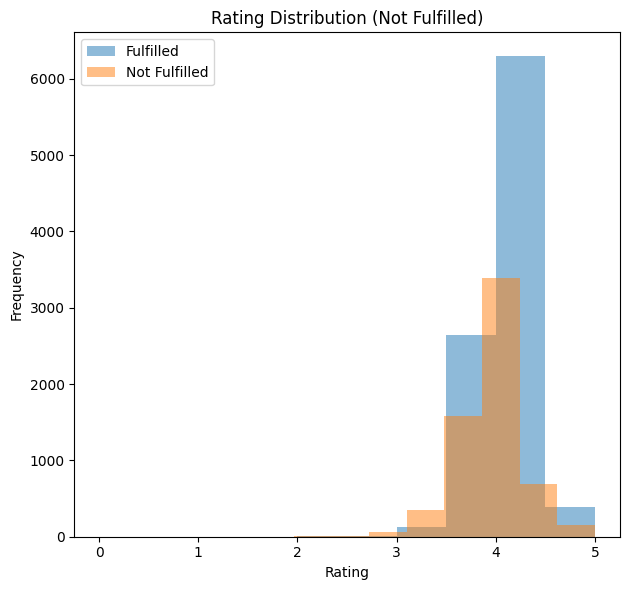

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

# Features and target variable (handle missing values with imputation here)
X = data['Rating'].to_numpy().reshape(-1, 1)
y = data['fulfilled1']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# Check data type
data_type = data['fulfilled1'].dtype
print(f"'fulfilled1' column data type: {data_type}")

# Handle filtering based on data type
if pd.api.types.is_string_dtype(data['fulfilled1']):
    # Filter assuming string type (lowercase for consistency)
    fulfilled_data = data[data['fulfilled1'].str.lower() == 'fulfilled']
    not_fulfilled_data = data[data['fulfilled1'].str.lower() != 'fulfilled']
elif pd.api.types.is_numeric_dtype(data['fulfilled1']):
    # Filter assuming numeric type (assuming specific values for fulfilled/not fulfilled)
    fulfilled_data = data[data['fulfilled1'] == 1]  # Replace with appropriate value for fulfilled
    not_fulfilled_data = data[data['fulfilled1'] != 1]  # Replace with appropriate value for not fulfilled
else:
    # Handle other data types or provide a warning
    print("Warning: 'fulfilled1' column has unexpected data type. Filtering might be inaccurate.")
    # You might need to create separate logic based on the data types present

# Create separate histograms (assuming filtering worked)
plt.figure(figsize=(12, 6))

# Fulfilled orders
plt.subplot(1, 2, 2)
plt.hist(fulfilled_data['Rating'], bins=10, alpha=0.5, label='Fulfilled')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution (Fulfilled)')
plt.legend()

# Not fulfilled orders
plt.subplot(1, 2, 2)
plt.hist(not_fulfilled_data['Rating'], bins=10, alpha=0.5, label='Not Fulfilled')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution (Not Fulfilled)')
plt.legend()

plt.tight_layout()
plt.show()
